# Jun 9th, 2022 (entropy (clean) k=7,10,14: GABAN 512)

**Motivation**: <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.network import *
from analysis.group import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
mice = Mice(512)

_BOLD = 'BOLD'
_CAS = r'Ca$^{2\!\!+}$' + ' (slow)'
_CAF = r'Ca$^{2\!\!+}$' + ' (fast)'
mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {_BOLD: rocket(0.6), _CAS: mako(0.6), _CAF: to_rgb('C8')} # mako(0.3)}

In [3]:
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

### Ca2 (fast)

In [4]:
%%time

b = 0.5
mice.setup_func_data(task, band_ca=b)

pi_caf_avg = {}

try:
    f = f"pi-pr-dict_n{mice.cfg.nn}_ca2-fast.npy"
    pi_caf_pr = np.load(pjoin(tmp_dir, f), allow_pickle=True).item()
    for kk in [7, 10, 14]:
        lbl = f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_caf_avg[lbl] = avg(pi_caf_pr.get(kk))
        
except FileNotFoundError:
    pi_caf_raw = {}
    pi_caf_pr = {}
    for kk in [7, 10, 14]:
        props_ca['num_k'] = kk
        gr_ca = Group(**props_ca).fit_group()
        pi_caf_raw[kk] = gr_ca.run_pi

        pi = gr_ca.prune(thres=0.003, ci=0.95)['pi_prune']
        pi_caf_pr[kk] = pi

        lbl = f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_caf_avg[lbl] = avg(pi)
    
    save_obj(
        obj=pi_caf_pr,
        file_name=f"pi-pr-dict_n{mice.cfg.nn}_ca2-fast",
        save_dir=tmp_dir,
        mode='npy',
    )


# sort
d2p = pi_caf_avg.copy()
for i in range(len(pi_caf_avg)):
    lbl, x = list(pi_caf_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

CPU times: user 1.4 s, sys: 5.09 s, total: 6.48 s
Wall time: 8.93 s


In [5]:
%%time

b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

pi_ca_avg = {}

try:
    f = f"pi-pr-dict_n{mice.cfg.nn}_ca2-slow.npy"
    pi_ca_pr = np.load(pjoin(tmp_dir, f), allow_pickle=True).item()
    for kk in [7, 10, 14]:
        lbl = f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_ca_avg[lbl] = avg(pi_ca_pr.get(kk))
        
except FileNotFoundError:
    pi_ca_raw = {}
    pi_ca_pr = {}
    for kk in [7, 10, 14]:
        props_ca['num_k'] = kk
        gr_ca = Group(**props_ca).fit_group()
        pi_ca_raw[kk] = gr_ca.run_pi

        pi = gr_ca.prune(thres=0.003, ci=0.95)['pi_prune']
        pi_ca_pr[kk] = pi

        lbl = f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_ca_avg[lbl] = avg(pi)
    
    save_obj(
        obj=pi_ca_pr,
        file_name=f"pi-pr-dict_n{mice.cfg.nn}_ca2",
        save_dir=tmp_dir,
        mode='npy',
    )


# sort
d2p = pi_ca_avg.copy()
for i in range(len(pi_ca_avg)):
    lbl, x = list(pi_ca_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

CPU times: user 1.42 s, sys: 5.04 s, total: 6.47 s
Wall time: 8.91 s


### Bold

In [6]:
%%time

pi_bo_avg = {}

try:
    f = f"pi-pr-dict_n{mice.cfg.nn}_bold.npy"
    pi_bo_pr = np.load(pjoin(tmp_dir, f), allow_pickle=True).item()
    for kk in [7, 10, 14]:
        lbl = f'bo-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_bo_avg[lbl] = avg(pi_bo_pr.get(kk))
        
except FileNotFoundError:
    pi_bo_raw = {}
    pi_bo_pr = {}
    for kk in [7, 10, 14]:
        props_bo['num_k'] = kk
        gr_bo = Group(**props_bo).fit_group()
        pi_bo_raw[kk] = gr_bo.run_pi

        pi = gr_bo.prune(thres=0.003, ci=0.95)['pi_prune']
        pi_bo_pr[kk] = pi

        lbl = f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_bo_avg[lbl] = avg(pi)
    
    save_obj(
        obj=pi_bo_pr,
        file_name=f"pi-pr-dict_n{mice.cfg.nn}_bold",
        save_dir=tmp_dir,
        mode='npy',
    )


# sort
d2p = pi_bo_avg.copy()
for i in range(len(pi_bo_avg)):
    lbl, x = list(pi_bo_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

CPU times: user 2.6 s, sys: 9.8 s, total: 12.4 s
Wall time: 17.5 s


## Calculate entropies

In [7]:
h_all = collections.defaultdict(dict)
for kk in pi_bo_pr:
    h_all[kk][_BOLD] = sp_stats.entropy(bn.nanmean(pi_bo_pr[kk], -3), axis=-2) / np.log(kk)
    h_all[kk][_CAS] = sp_stats.entropy(bn.nanmean(pi_ca_pr[kk], -3), axis=-2) / np.log(kk)
    h_all[kk][_CAF] = sp_stats.entropy(bn.nanmean(pi_caf_pr[kk], -3), axis=-2) / np.log(kk)

### Distribution (run and grp)

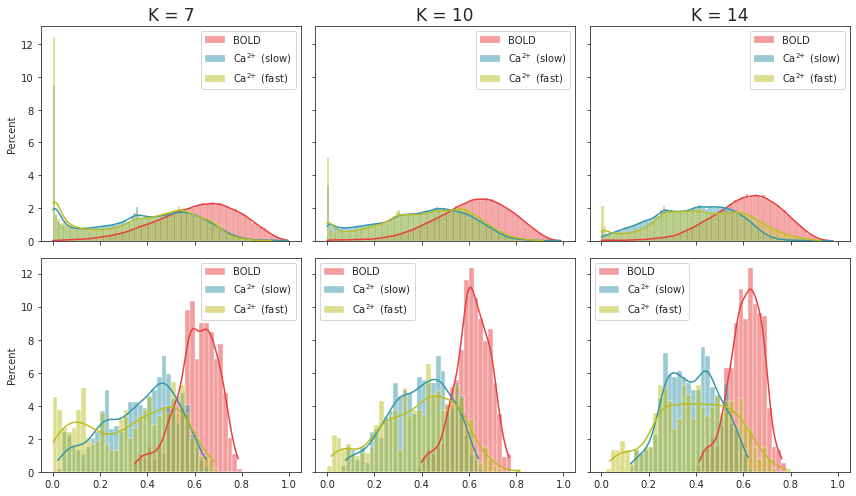

In [8]:
fig, axes = create_figure(2, 3, (12, 7), 'all', 'row')

for j, (kk, h_dict) in enumerate(h_all.items()):
    for lbl, x in h_dict.items():
        ax = axes[0, j]
        sns.histplot(
            x[np.isfinite(x)],
            bins=np.linspace(0, 1, 101),
            stat='percent',
            color=pal[lbl],
            label=lbl,
            kde=True,
            ax=ax,
        )
        ax.set_title(f"K = {kk}", fontsize=17)
        ax.legend()
        
        ax = axes[1, j]
        sns.histplot(
            avg(x, 1),
            bins=np.linspace(0, 1, 51),
            stat='percent',
            color=pal[lbl],
            label=lbl,
            kde=True,
            ax=ax,
        )
        ax.legend()
        
plt.show()

In [9]:
h_avg = np_nans((3, 3, len(gr_bo.n2l)))
hr_avg = np_nans((3, 3, len(gr_bo.n2l)))
for j, h_dict in enumerate(h_all.values()):
    for i, (lbl, x) in enumerate(h_dict.items()):
        _x = avg(x, 1)
        h_avg[i, j] = _x
        hr_avg[i, j][np.isfinite(_x)] = sp_stats.rankdata(_x[np.isfinite(_x)])

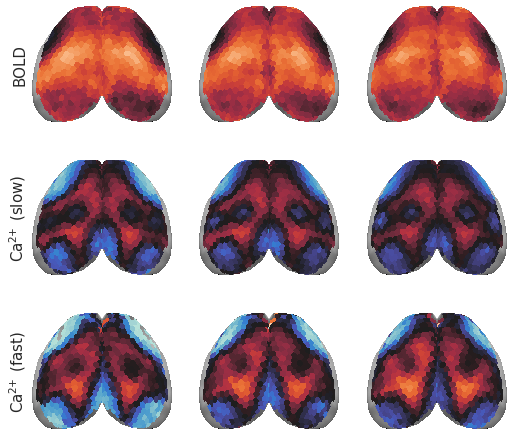

(0.0024836469039461076, 0.8140533407639594)

In [10]:
vmin = np.nanmin(h_avg)
vmax = np.nanmax(h_avg)

_ = gr_ca.show(
    data={
        lbl: h_avg[i] for i, lbl in
        enumerate([_BOLD, _CAS, _CAF])},
    vmin=vmin,
    vmax=vmax,
    cmap='icefire',
    figsize=(8.5, 8),
    ylabel_fontsize=15,
    add_disjoint=False,
)
vmin, vmax

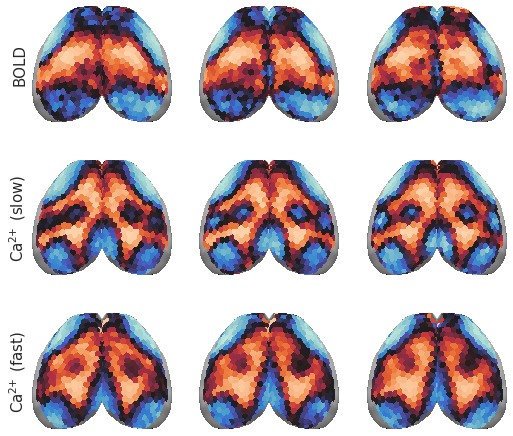

(1.0, 542.0)

In [11]:
vmin = np.nanmin(hr_avg)
vmax = np.nanmax(hr_avg)

_ = gr_ca.show(
    data={
        lbl: hr_avg[i] for i, lbl in
        enumerate([_BOLD, _CAS, _CAF])},
    vmin=vmin,
    vmax=vmax,
    cmap='icefire',
    figsize=(8.5, 8),
    ylabel_fontsize=15,
    add_disjoint=False,
)
vmin, vmax

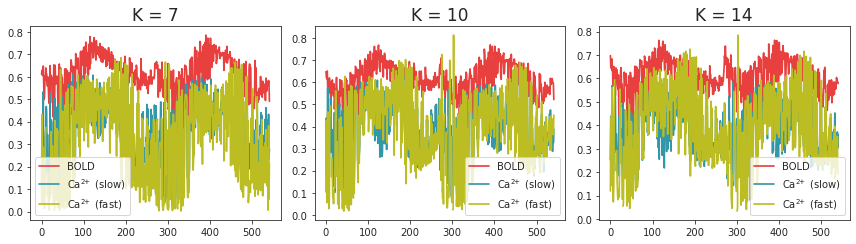

In [12]:
fig, axes = create_figure(1, 3, (12, 3.5))

for j, kk in enumerate(h_all):
    for i, lbl in enumerate([_BOLD, _CAS, _CAF]):
        axes[j].plot(h_avg[i, j], lw=1.7, color=pal[lbl], label=lbl)
    axes[j].set_title(f"K = {kk}", fontsize=17)
    axes[j].legend()
plt.show()

In [13]:
df = {
    _BOLD: h_avg[0].ravel(),
    _CAS: h_avg[1].ravel(),
    _CAF: h_avg[2].ravel(),
    'K': np.repeat([7, 10, 14], h_avg.shape[-1]),
}
df = pd.DataFrame(df)

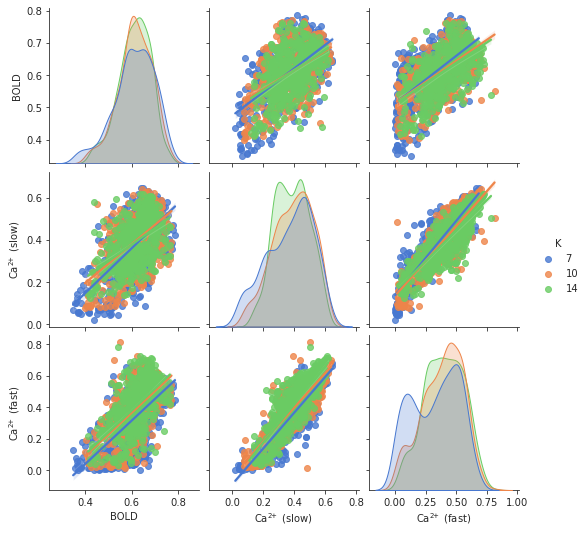

In [14]:
pg = sns.pairplot(
    data=df,
    hue='K',
    kind='reg',
    diag_kind='kde',
    palette='muted',
)
plt.show()

In [15]:
def corr(x, y, kind='spearman'):
    good = np.logical_and(np.isfinite(x), np.isfinite(y))
    if kind == 'spearman':
        return sp_stats.spearmanr(x[good], y[good]).correlation
    elif kind == 'pearson':
        return sp_stats.pearsonr(x[good], y[good])[0]

In [16]:
jj = 1

In [17]:
msg = '--- Spearman r ---\n\n'
msg += f"BOLD vs. Ca (slow):  {corr(h_avg[0, jj], h_avg[1, jj], 'spearman'):0.3f}\n"
msg += f"BOLD vs. Ca (fast):  {corr(h_avg[0, jj], h_avg[2, jj], 'spearman'):0.3f}\n"
msg += f"Ca (slow) vs. Ca (fast):  {corr(h_avg[1, jj], h_avg[2, jj], 'spearman'):0.3f}\n"
print(msg)

--- Spearman r ---

BOLD vs. Ca (slow):  0.497
BOLD vs. Ca (fast):  0.603
Ca (slow) vs. Ca (fast):  0.827

In [41]:
msg = '--- Pearson r ---\n\n'
msg += f"BOLD vs. Ca (slow):  {corr(h_avg[0, jj], h_avg[1, jj], 'pearson'):0.3f}\n"
msg += f"BOLD vs. Ca (fast):  {corr(h_avg[0, jj], h_avg[2, jj], 'pearson'):0.3f}\n"
msg += f"Ca (slow) vs. Ca (fast):  {corr(h_avg[1, jj], h_avg[2, jj], 'pearson'):0.3f}\n"
print(msg)

--- Pearson r ---

BOLD vs. Ca (slow):  0.523
BOLD vs. Ca (fast):  0.601
Ca (slow) vs. Ca (fast):  0.850

In [19]:
bins = np.linspace(0, 1, 51)
xx = (bins[:-1] + bins[1:]) / 2

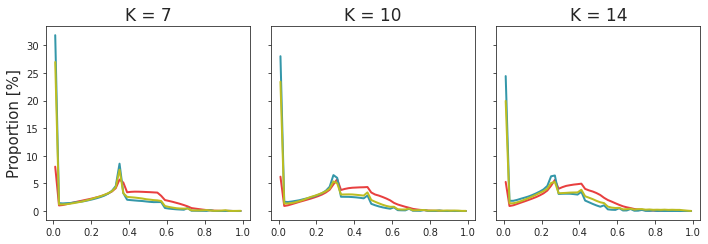

In [20]:
fig, axes = create_figure(1, 3, (10, 3.5), 'all', 'all')
for j, kk in enumerate([7, 10, 14]):
    h_bo = sp_stats.entropy(pi_bo_pr[kk], axis=-2) / np.log(kk)
    h_ca = sp_stats.entropy(pi_ca_pr[kk], axis=-2) / np.log(kk)
    h_caf = sp_stats.entropy(pi_caf_pr[kk], axis=-2) / np.log(kk)

    cut_bo = cut_data(
        data=h_bo.reshape(-1, 1, h_bo.shape[-1]),
        bins=bins,
        oc_only=True,
    )[0].reshape(*h_bo.shape[:4], -1)
    cut_avg_bo = avg(cut_bo, 1)

    cut_ca = cut_data(
        data=h_ca.reshape(-1, 1, h_ca.shape[-1]),
        bins=bins,
        oc_only=True,
    )[0].reshape(*h_ca.shape[:4], -1)
    cut_avg_ca = avg(cut_ca, 1)

    cut_caf = cut_data(
        data=h_caf.reshape(-1, 1, h_caf.shape[-1]),
        bins=bins,
        oc_only=True,
    )[0].reshape(*h_caf.shape[:4], -1)
    cut_avg_caf = avg(cut_caf, 1)

    axes[j].plot(xx, cut_avg_bo, color=pal[_BOLD], label=_BOLD, lw=2)
    axes[j].plot(xx, cut_avg_ca, color=pal[_CAS], label=_CAS, lw=2)
    axes[j].plot(xx, cut_avg_caf, color=pal[_CAF], label=_CAF, lw=2)
    axes[j].set_title(f"K = {kk}", fontsize=17)
axes[0].set_ylabel('Proportion [%]', fontsize=15)
plt.show()

## Difference map (H)

In [21]:
from statsmodels.stats.multitest import fdrcorrection

### ca slow vs bo (kk = 7)

In [22]:
kk = 7
pi_bo = bn.nanmean(pi_bo_pr[kk], -3)
pi_ca = bn.nanmean(pi_ca_pr[kk], -3)
pi_caf = bn.nanmean(pi_caf_pr[kk], -3)

h_bo = sp_stats.entropy(pi_bo, axis=-2) / np.log(kk)
h_ca = sp_stats.entropy(pi_ca, axis=-2) / np.log(kk)
h_caf = sp_stats.entropy(pi_caf, axis=-2) / np.log(kk)

In [23]:
y1 = h_bo.reshape(-1, h_bo.shape[-1])
y2 = h_ca.reshape(-1, h_ca.shape[-1])
y3 = h_caf.reshape(-1, h_caf.shape[-1])

good_runs = ~np.logical_or(
    np.isnan(y1).sum(1) == y1.shape[-1],
    np.isnan(y2).sum(1) == y2.shape[-1],
    np.isnan(y3).sum(1) == y3.shape[-1],
)
good_runs.sum()

108

In [24]:
y1 = y1[good_runs]
y2 = y2[good_runs]
y3 = y3[good_runs]

In [25]:
def statistic(a, b, axis):
    return bn.nanmean(a - b, axis=axis)

In [26]:
good_nodes = np.logical_and(
    np.isnan(y1).sum(0) < good_runs.sum() // 2,
    np.isnan(y2).sum(0) < good_runs.sum() // 2,
)
good_nodes.sum()

495

In [27]:
%%time

test = sp_stats.permutation_test(
    data=(y1[:, good_nodes], y2[:, good_nodes]),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e4),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

CPU times: user 8.13 s, sys: 14 ms, total: 8.14 s
Wall time: 8.14 s


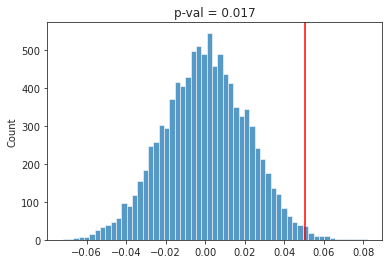

In [28]:
ii = 38

sns.histplot(test.null_distribution[:, ii])
plt.axvline(test.statistic[ii], color='r')
plt.title(f"p-val = {test.pvalue[ii]:0.2g}")
plt.show()

In [29]:
rejected, pvals_corrected = fdrcorrection(test.pvalue, method='p')
rejected.sum(), np.array_equal(pvals_corrected < 0.05, rejected)

(476, True)

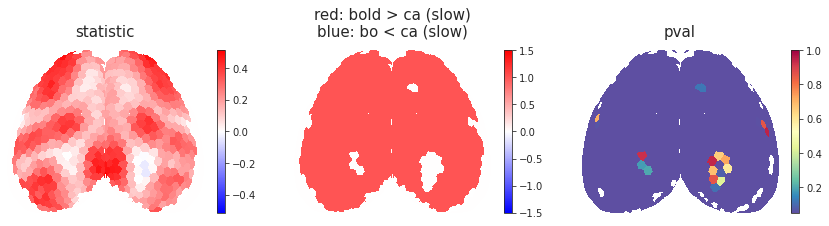

In [30]:
_statistic = np_nans(h_bo.shape[-1])
_pvalues = np_nans(h_bo.shape[-1])

_statistic[good_nodes] = test.statistic
_pvalues[good_nodes] = pvals_corrected

tr_statistic = gr_ca.project_vec(_statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue_corrected = gr_ca.project_vec(_pvalues, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue_corrected = gr_ca.trim2d(tr_pvalue_corrected)


fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.nanmax(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue_corrected['proj-top'][0] >= alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue_corrected['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bold > ca (slow)\nblue: bo < ca (slow)', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue_corrected['top'] == 0, tr_pvalue_corrected['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [31]:
good_nodes = np.logical_and(
    np.isnan(y1).sum(0) < good_runs.sum() // 2,
    np.isnan(y3).sum(0) < good_runs.sum() // 2,
)
good_nodes.sum()

416

In [32]:
%%time

test = sp_stats.permutation_test(
    data=(y1[:, good_nodes], y3[:, good_nodes]),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e4),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

CPU times: user 7.14 s, sys: 6.7 ms, total: 7.15 s
Wall time: 7.15 s


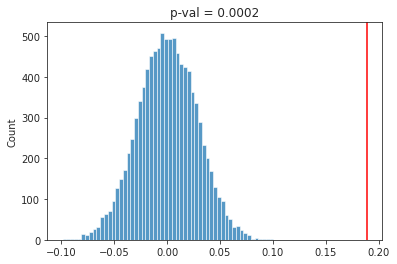

In [33]:
ii = 38

sns.histplot(test.null_distribution[:, ii])
plt.axvline(test.statistic[ii], color='r')
plt.title(f"p-val = {test.pvalue[ii]:0.2g}")
plt.show()

In [34]:
rejected, pvals_corrected = fdrcorrection(test.pvalue, method='p')
rejected.sum(), np.array_equal(pvals_corrected < 0.05, rejected)

(400, True)

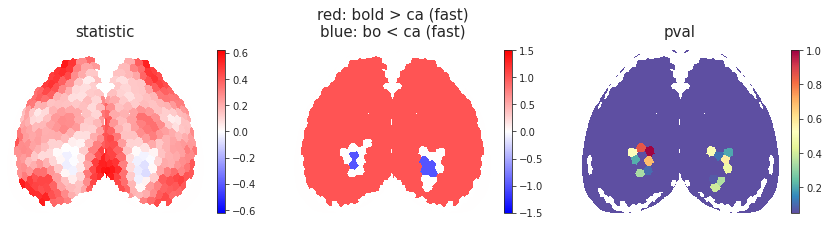

In [35]:
_statistic = np_nans(h_bo.shape[-1])
_pvalues = np_nans(h_bo.shape[-1])

_statistic[good_nodes] = test.statistic
_pvalues[good_nodes] = pvals_corrected


tr_statistic = gr_ca.project_vec(_statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue_corrected = gr_ca.project_vec(_pvalues, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue_corrected = gr_ca.trim2d(tr_pvalue_corrected)


fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.nanmax(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue_corrected['proj-top'][0] >= alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue_corrected['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bold > ca (fast)\nblue: bo < ca (fast)', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue_corrected['top'] == 0, tr_pvalue_corrected['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [36]:
good_nodes = np.logical_and(
    np.isnan(y2).sum(0) < good_runs.sum() // 2,
    np.isnan(y3).sum(0) < good_runs.sum() // 2,
)
good_nodes.sum()

417

In [37]:
%%time

test = sp_stats.permutation_test(
    data=(y2[:, good_nodes], y3[:, good_nodes]),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e4),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

CPU times: user 7.13 s, sys: 11 ms, total: 7.14 s
Wall time: 7.14 s


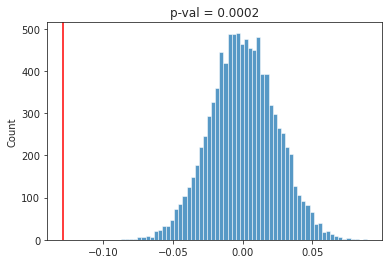

In [38]:
ii = 38

sns.histplot(test.null_distribution[:, ii])
plt.axvline(test.statistic[ii], color='r')
plt.title(f"p-val = {test.pvalue[ii]:0.2g}")
plt.show()

In [39]:
rejected, pvals_corrected = fdrcorrection(test.pvalue, method='p')
rejected.sum(), np.array_equal(pvals_corrected < 0.05, rejected)

(260, True)

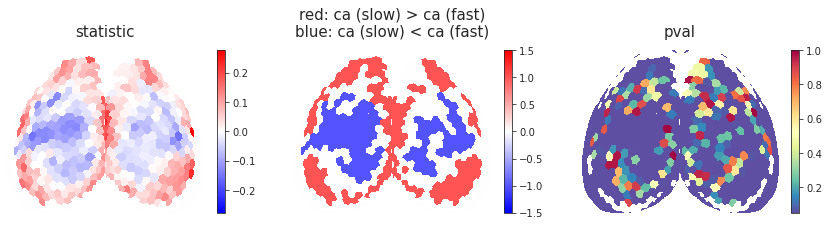

In [40]:
_statistic = np_nans(h_bo.shape[-1])
_pvalues = np_nans(h_bo.shape[-1])

_statistic[good_nodes] = test.statistic
_pvalues[good_nodes] = pvals_corrected


tr_statistic = gr_ca.project_vec(_statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue_corrected = gr_ca.project_vec(_pvalues, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue_corrected = gr_ca.trim2d(tr_pvalue_corrected)


fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.nanmax(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue_corrected['proj-top'][0] >= alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue_corrected['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: ca (slow) > ca (fast)\nblue: ca (slow) < ca (fast)', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue_corrected['top'] == 0, tr_pvalue_corrected['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()